1. Import Liblary

In [1]:
pip install tensorflow keras numpy pandas tqdm scikit-learn matplotlib seaborn pillow opencv-python ultralytics

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from ultralytics import YOLO
import numpy as np
import zipfile
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML
# stop annoying tensorflow warning messages
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

2. Define fungsi untuk menampilkan contoh Training Image

In [3]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

3. Define fungsi untuk print text dalam RGB dan Background Colors

In [4]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #mencetak text_msg dalam warna latar depan yang ditentukan oleh fore_tupple dengan latar belakang yang ditentukan oleh back_tupple
    #text_msg adalah teks, fore_tupple adalah tupple warna latar depan (r,g,b), back_tupple adalah tupple latar belakang (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # mengembalikan warna cetak default menjadi hitam kembali
    return

4. Define subclass dari Keras callbacks untuk mengontrol Learning Rate dan print training data dalam format spreadsheet. Callback disini juga berfungsi untuk menanyakan secara berkala apakah lanjut training selama N epoch atau Halt (berhenti)

In [5]:
class LRA(Callback):
    def __init__(self, model, base_model, patience, stop_patience, threshold, factor, dwell, batches, initial_epoch, epochs, ask_epoch):
        super(LRA, self).__init__()
        self.model = model
        self.base_model = base_model
        self.patience = patience
        self.stop_patience = stop_patience
        self.threshold = threshold
        self.factor = factor
        self.dwell = dwell
        self.batches = batches
        self.initial_epoch = initial_epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch
        self.count = 0
        self.stop_count = 0
        self.best_epoch = 1
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))
        self.highest_tracc = 0.0
        self.lowest_vloss = np.inf
        self.best_weights = self.model.get_weights()
        self.initial_weights = self.model.get_weights()

    def on_epoch_end(self, epoch, logs=None):
        v_loss = logs.get('val_loss')
        v_acc = logs.get('val_accuracy')

        if v_loss < 0.05 and v_acc > 0.95:
            msg = f'Pelatihan dihentikan karena kinerja sudah cukup baik di epoch {epoch+1}.'
            self.print_in_color(msg, (0, 255, 255), (55, 65, 80))
            self.model.stop_training = True
        elif self.stop_count > self.stop_patience - 1:
            msg = f'Pelatihan dihentikan setelah {self.stop_patience} pengurangan LR tanpa perbaikan.'
            self.print_in_color(msg, (0, 255, 255), (55, 65, 80))
            self.model.stop_training = True
        else:
            # Early stopping logic and adjustments based on learning rate
            if v_loss < self.lowest_vloss:
                self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1
                self.best_weights = self.model.get_weights()
                self.stop_count = 0
            else:
                self.stop_count += 1

            if self.stop_count >= self.patience:
                new_lr = self.initial_lr * self.factor
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
                msg = f'Learning rate dikurangi menjadi {new_lr} pada epoch {epoch+1}.'
                self.print_in_color(msg, (255, 255, 255), (255, 0, 0))
                self.stop_count = 0
                self.count += 1

                if self.count >= self.dwell:
                    msg = f'Pembelajaran berhenti setelah {self.dwell} penurunan learning rate.'
                    self.print_in_color(msg, (0, 255, 255), (55, 65, 80))
                    self.model.stop_training = True

            # Ask to continue training after specified epochs
            if (epoch + 1) % self.ask_epoch == 0:
                user_input = input(f"Apakah Anda ingin melanjutkan pelatihan setelah epoch {epoch+1}? (y/n): ")
                if user_input.lower() == 'n':
                    self.model.stop_training = True

    # Helper function to print colored messages
    def print_in_color(self, text, text_color, bg_color):
        print(f"\033[38;2;{text_color[0]};{text_color[1]};{text_color[2]}m\033[48;2;{bg_color[0]};{bg_color[1]};{bg_color[2]}m{text}\033[0m")


5. Define fungsi untuk plot training data

In [6]:
def tr_plot(tr_data, start_epoch):
    # Mengambil data dari riwayat pelatihan
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    
    # Menentukan jumlah epoch yang telah berjalan
    Epoch_count = len(tacc) + start_epoch
    Epochs = [i + 1 for i in range(start_epoch, Epoch_count)]
    
    # Menemukan epoch dengan loss validasi terkecil dan akurasi validasi terbesar
    index_loss = np.argmin(vloss)  # Epoch dengan validasi loss terkecil
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)  # Epoch dengan akurasi validasi tertinggi
    acc_highest = vacc[index_acc]
    
    # Menyiapkan label untuk titik terbaik
    sc_label = 'Best epoch (loss) = ' + str(index_loss + 1 + start_epoch)
    vc_label = 'Best epoch (accuracy) = ' + str(index_acc + 1 + start_epoch)
    
    # Membuat subplot untuk dua grafik: loss dan akurasi
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    
    # Plot untuk Training dan Validation Loss
    axes[0].plot(Epochs, tloss, 'r', label='Training Loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation Loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    
    # Plot untuk Training dan Validation Accuracy
    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    # Layout yang rapi untuk plot
    plt.tight_layout()
    plt.show()


6. Define fungsi untuk membuat confusion matrix dan classification report

In [7]:
def print_info(test_gen, preds, print_code, save_dir, subject):
    class_dict = test_gen.class_indices
    labels = test_gen.labels
    file_names = test_gen.filenames
    error_list = []
    true_class = []
    pred_class = []
    prob_list = []
    new_dict = {}
    error_indices = []
    y_pred = []

    # Membuat kamus untuk memetakan indeks kelas integer ke nama kelas
    for key, value in class_dict.items():
        new_dict[value] = key  # {indeks kelas integer: nama kelas string}
    
    # Simpan kamus kelas ke file teks di direktori simpan
    classes = list(new_dict.values())  # Daftar nama kelas
    errors = 0
    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        true_index = labels[i]  # Label adalah nilai integer
        if pred_index != true_index:  # Terjadi kesalahan klasifikasi
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors += 1
        y_pred.append(pred_index)

    # Cetak rincian kesalahan jika ada kesalahan
    if print_code != 0:
        if errors > 0:
            if print_code > errors:
                r = errors
            else:
                r = print_code
            msg = '{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Nama File', 'Kelas Prediksi', 'Kelas Sebenarnya', 'Probabilitas')
            print_in_color(msg, (0, 255, 0), (55, 65, 80))
            for i in range(r):
                split1 = os.path.split(error_list[i])
                split2 = os.path.split(split1[0])
                fname = split2[1] + '/' + split1[1]
                msg = '{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i], true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255, 255, 255), (55, 65, 60))
        else:
            msg = 'Dengan akurasi 100%, tidak ada kesalahan yang perlu dicetak'
            print_in_color(msg, (0, 255, 0), (55, 65, 80))

    # Plot kesalahan berdasarkan kelas
    if errors > 0:
        plot_bar = []
        plot_class = []
        for key, value in new_dict.items():
            count = error_indices.count(key)
            if count != 0:
                plot_bar.append(count)  # Daftar yang berisi jumlah kesalahan per kelas
                plot_class.append(value)  # Menyimpan kelas
        fig = plt.figure()
        fig.set_figheight(len(plot_class) / 3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c = plot_class[i]
            x = plot_bar[i]
            plt.barh(c, x)
        plt.title('Kesalahan Berdasarkan Kelas pada Set Pengujian')
        plt.show()

    # Membuat confusion matrix dan classification report
    y_true = np.array(labels)
    y_pred = np.array(y_pred)
    if len(classes) <= 30:
        # Menghasilkan confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        length = len(classes)
        fig_width = 8 if length < 8 else int(length * 0.5)
        fig_height = 8 if length < 8 else int(length * 0.5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length) + 0.5, classes, rotation=90)
        plt.yticks(np.arange(length) + 0.5, classes, rotation=0)
        plt.xlabel("Prediksi")
        plt.ylabel("Sebenarnya")
        plt.title("Confusion Matrix")
        plt.show()

    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Laporan Klasifikasi:\n----------------------\n", clr)


7. Define fungsi untuk menyimpan model dan associated class_dict.csv file

In [8]:
def saver(save_path, model, model_name, subject, accuracy, img_size, scalar, generator):
    # Pertama, simpan model
    save_id = str(model_name + '-' + subject + '-' + str(accuracy)[:str(accuracy).rfind('.')+3] + '.h5')
    model_save_loc = os.path.join(save_path, save_id)
    model.save(model_save_loc)
    print_in_color('Model disimpan sebagai ' + model_save_loc, (0, 255, 0), (55, 65, 80))

    # Sekarang buat class_df dan konversikan ke file CSV
    class_dict = generator.class_indices
    height = []
    width = []
    scale = []
    for i in range(len(class_dict)):
        height.append(img_size[0])
        width.append(img_size[1])
        scale.append(scalar)
    
    # Membuat DataFrame dengan informasi kelas
    Index_series = pd.Series(list(class_dict.values()), name='class_index')
    Class_series = pd.Series(list(class_dict.keys()), name='class')
    Height_series = pd.Series(height, name='height')
    Width_series = pd.Series(width, name='width')
    Scale_series = pd.Series(scale, name='scale by')
    class_df = pd.concat([Index_series, Class_series, Height_series, Width_series, Scale_series], axis=1)
    
    # Menyimpan DataFrame ke file CSV
    csv_name = 'Eye_Diseases.csv'
    csv_save_loc = os.path.join(save_path, csv_name)
    class_df.to_csv(csv_save_loc, index=False)
    print_in_color('File CSV kelas disimpan sebagai ' + csv_save_loc, (0, 255, 0), (55, 65, 80))
    
    return model_save_loc, csv_save_loc


8. Definisikan fungsi untuk menggunakan model terlatih untuk prediksi

In [9]:
def classify(sdir, csv_path, model_path, crop_image=False):
    # Membaca file CSV
    class_df = pd.read_csv(csv_path)
    img_height = int(class_df['height'].iloc[0])
    img_width = int(class_df['width'].iloc[0])
    img_size = (img_height, img_width)
    scale = class_df['scale by'].iloc[0]
    
    # Menentukan skala
    try:
        s = int(scale)
        s2 = 1
        s1 = 0
    except:
        split = scale.split('-')
        s1 = float(split[1])
        s2 = float(split[0].split('*')[1])
        print(s1, s2)
    
    # Membaca daftar file citra dari direktori
    path_list = []
    paths = os.listdir(sdir)
    for f in paths:
        path_list.append(os.path.join(sdir, f))
    
    print('Model sedang dimuat - ini akan memakan waktu sekitar 10 detik')
    model = load_model(model_path)
    
    image_count = len(path_list)
    index_list = []
    prob_list = []
    cropped_image_list = []
    good_image_count = 0
    
    for i in range(image_count):
        img = plt.imread(path_list[i])
        
        # Memangkas citra jika crop_image diaktifkan
        if crop_image:
            status, img = crop(img)
        else:
            status = True
        
        if status:
            good_image_count += 1
            img = cv2.resize(img, img_size)
            print('Citra ukuran:', img.shape)
            cropped_image_list.append(img)
            img = img * s2 - s1
            img = np.expand_dims(img, axis=0)
            p = np.squeeze(model.predict(img))
            index = np.argmax(p)
            print(index)
            prob = p[index]
            index_list.append(index)
            prob_list.append(prob)
    
    # Menghasilkan hasil untuk satu citra yang baik
    if good_image_count == 1:
        class_name = class_df['class'].iloc[index_list[0]]
        probability = prob_list[0]
        img = cropped_image_list[0]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
        plt.imshow(img)
        return class_name, probability
    
    # Jika tidak ada citra yang baik
    elif good_image_count == 0:
        return None, None
    
    # Menghitung kelas yang paling sering muncul
    most = 0
    for i in range(len(index_list)-1):
        key = index_list[i]
        keycount = 0
        for j in range(i+1, len(index_list)):
            nkey = index_list[j]
            if nkey == key:
                keycount += 1
        if keycount > most:
            most = keycount
            isave = i
    
    best_index = index_list[isave]
    psum = 0
    bestsum = 0
    for i in range(len(index_list)):
        psum += prob_list[i]
        if index_list[i] == best_index:
            bestsum += prob_list[i]
    
    img = cropped_image_list[isave] / 255
    class_name = class_df['class'].iloc[best_index]
    plt.title(class_name, color='blue', fontsize=16)
    plt.axis('off')
    plt.imshow(img)
    
    return class_name, bestsum / image_count


9.  Import Citra

In [10]:
# Path ke file ZIP
zip_file_path = r"C:\Users\RISKI ABDILAH\OneDrive\Desktop\Project SCP Research\archive.zip"  # Gunakan 'r' untuk raw string agar path Windows diterima

# Lokasi untuk ekstraksi file
extract_to = "Eye_Diseases"  # Direktori tempat file akan diekstrak

# Ekstrak file ZIP
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)  # Ekstrak semua file ke folder 'extracted_data'

# Dapatkan daftar file dalam folder ekstraksi
extracted_files = []
for root, _, files in os.walk(extract_to):
    for file in files:
        extracted_files.append(os.path.join(root, file))  # Simpan path lengkap setiap file

print("File yang diekstrak:")
for file in extracted_files:
    print(file)

# Temukan dan baca semua file CSV
csv_files = [file for file in extracted_files if file.endswith(".csv")]

if csv_files:
    print("\nFile CSV yang ditemukan:")
    for csv_file in csv_files:
        print(csv_file)
        try:
            # Baca setiap file CSV
            data = pd.read_csv(csv_file)
            print(f"\nData dari file {os.path.basename(csv_file)}:")
            print(data.head())  # Tampilkan 5 baris pertama
        except Exception as e:
            print(f"Error membaca file {csv_file}: {e}")
else:
    print("Tidak ada file CSV yang ditemukan di dalam ZIP.")


File yang diekstrak:
Eye_Diseases\dataset\cataract\0_left.jpg
Eye_Diseases\dataset\cataract\103_left.jpg
Eye_Diseases\dataset\cataract\1062_right.jpg
Eye_Diseases\dataset\cataract\1083_left.jpg
Eye_Diseases\dataset\cataract\1084_right.jpg
Eye_Diseases\dataset\cataract\1102_left.jpg
Eye_Diseases\dataset\cataract\1102_right.jpg
Eye_Diseases\dataset\cataract\1115_left.jpg
Eye_Diseases\dataset\cataract\1126_right.jpg
Eye_Diseases\dataset\cataract\112_right.jpg
Eye_Diseases\dataset\cataract\1144_left.jpg
Eye_Diseases\dataset\cataract\1144_right.jpg
Eye_Diseases\dataset\cataract\1164_left.jpg
Eye_Diseases\dataset\cataract\1167_right.jpg
Eye_Diseases\dataset\cataract\119_left.jpg
Eye_Diseases\dataset\cataract\1285_left.jpg
Eye_Diseases\dataset\cataract\1415_left.jpg
Eye_Diseases\dataset\cataract\1415_right.jpg
Eye_Diseases\dataset\cataract\1435_left.jpg
Eye_Diseases\dataset\cataract\1444_left.jpg
Eye_Diseases\dataset\cataract\1452_left.jpg
Eye_Diseases\dataset\cataract\1454_right.jpg
Eye_Dise

(256, 256, 3)


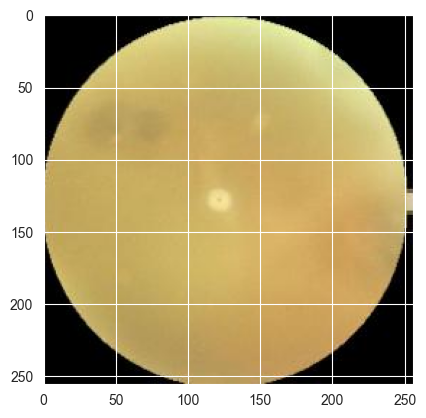

In [11]:
import matplotlib.pyplot as plt # Add this line at the beginning of the cell
fpath=r'C:\Users\RISKI ABDILAH\OneDrive\Desktop\Project SCP Research\Eye_Diseases\dataset\cataract\_0_4015166.jpg'
img=plt.imread(fpath) # Now 'plt' is recognized
print (img.shape)
plt.imshow(img)

11. Iterate direktori data dan membuat data frame kedalam filepaths dan labels

In [12]:
# Direktori dataset
sdir = r'C:\Users\RISKI ABDILAH\OneDrive\Desktop\Project SCP Research\Eye_Diseases\dataset'

# Membuat daftar file paths dan label
classlist = os.listdir(sdir)
filepaths = []
labels = []

for klass in classlist:
    classpath = os.path.join(sdir, klass)
    if os.path.isdir(classpath):  # Pastikan hanya folder yang diproses
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            filepaths.append(fpath)
            labels.append(klass)

# Membuat dataframe dari filepaths dan labels
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

# Membagi data ke dalam train, validation, dan test set
trsplit = 0.9  # Proporsi data training
vsplit = 0.05  # Proporsi data validasi
dsplit = vsplit / (1 - trsplit)  # Proporsi data validasi terhadap sisa data

train_df, dummy_df = train_test_split(df, train_size=trsplit, shuffle=True, random_state=123)
valid_df, test_df = train_test_split(dummy_df, train_size=dsplit, shuffle=True, random_state=123)

# Menampilkan informasi jumlah data
print('train_df length:', len(train_df), ' test_df length:', len(test_df), ' valid_df length:', len(valid_df))

# Menampilkan distribusi label pada training set
balance = train_df['labels'].value_counts()
print("\nDistribusi label di training set:")
for label, count in balance.items():
    print(f"{label}: {count}")


train_df length: 3795  test_df length: 211  valid_df length: 211

Distribusi label di training set:
diabetic_retinopathy: 992
normal: 961
cataract: 933
glaucoma: 909


12. Batasi sampel data di setiap kelas menjadi 906 untuk seimbang

In [13]:
sample_list = []
max_size = 906
min_size = 0
groups = train_df.groupby('labels')  # Menggunakan train_df yang sudah didefinisikan sebelumnya

for label in train_df['labels'].unique():
    group = groups.get_group(label)
    sample_count = len(group)
    
    if sample_count > max_size:
        samples = group.sample(max_size, replace=False, weights=None, random_state=123, axis=0).reset_index(drop=True)
        sample_list.append(samples)
    elif sample_count >= min_size:
        sample_list.append(group)

balanced_df = pd.concat(sample_list, axis=0).reset_index(drop=True)

# Menampilkan distribusi label setelah balancing
balance = list(balanced_df['labels'].value_counts())
print(balance)


[906, 906, 906, 906]


13. Membuat train, test, valid generators

In [14]:
# Fungsi untuk membuat data generators
def create_generators(dataframe, data_dir):
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    train_gen = datagen.flow_from_dataframe(
        dataframe, data_dir, x_col='filepaths', y_col='labels',
        target_size=(224, 224), batch_size=32, subset='training', class_mode='categorical')

    valid_gen = datagen.flow_from_dataframe(
        dataframe, data_dir, x_col='filepaths', y_col='labels',
        target_size=(224, 224), batch_size=32, subset='validation', class_mode='categorical')

    return train_gen, valid_gen

# Mendapatkan panjang dataset
length = len(test_df)

# Menghitung batch size dan steps untuk test generator
test_batch_size = sorted(
    [int(length / n) for n in range(1, length + 1) if length % n == 0 and length / n <= 80],
    reverse=True
)[0]
test_steps = int(length / test_batch_size)

print('Test batch size:', test_batch_size, ' Test steps:', test_steps)

# Fungsi preprocessing (scalar)
def scalar(img):
    """Fungsi preprocessing untuk memastikan skala piksel tetap dalam rentang 0-255,
    sesuai dengan kebutuhan EfficientNet."""
    return img

# ImageDataGenerator untuk data augmentation dan preprocessing
trgen = ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen = ImageDataGenerator(preprocessing_function=scalar)

# Data generator untuk training, validation, dan testing
train_gen, valid_gen = create_generators(train_df, 'train_directory')  # Update sesuai dengan direktori data training
test_gen = tvgen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=test_batch_size
)

# Mendapatkan daftar kelas dan jumlah kelas
classes = list(train_gen.class_indices.keys())
class_count = len(classes)

# Menghitung jumlah langkah per epoch untuk training
train_steps = np.ceil(len(train_gen.labels) / 32)

# Informasi tambahan
print('Classes:', classes)
print('Number of classes:', class_count)
print('Train steps per epoch:', train_steps)


Test batch size: 1  Test steps: 211
Found 3036 validated image filenames belonging to 4 classes.
Found 759 validated image filenames belonging to 4 classes.
Found 211 validated image filenames belonging to 4 classes.
Classes: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
Number of classes: 4
Train steps per epoch: 95.0


14. Membuat fungsi untuk menampilkan beberapa sample citra dari penyakit mata

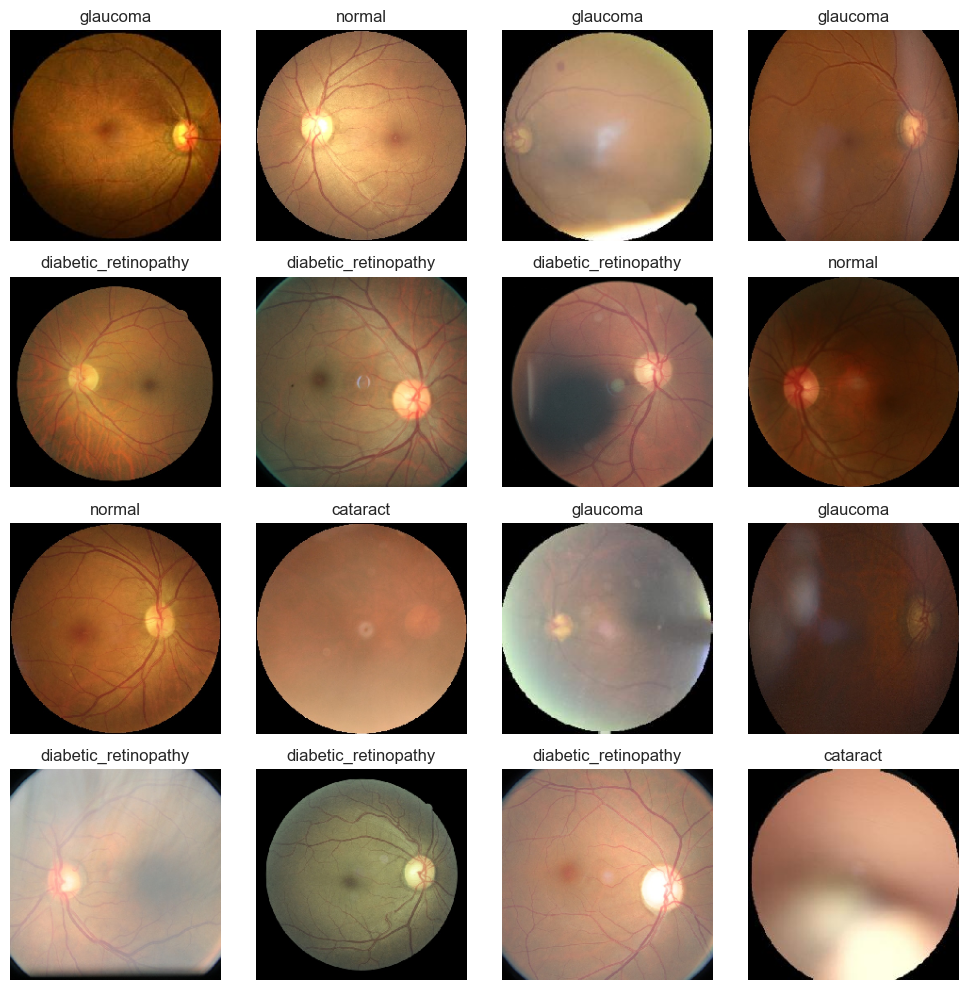

In [15]:
def show_image_samples(generator, num_samples=16):
    # Ambil satu batch dari generator
    images, labels = next(generator)

    # Batasi jumlah gambar sesuai num_samples
    images = images[:num_samples]
    labels = labels[:num_samples]

    # Menentukan jumlah baris dan kolom untuk subplot
    cols = int(np.ceil(np.sqrt(num_samples)))
    rows = int(np.ceil(num_samples / cols))

    # Menampilkan gambar
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(rows, cols, i + 1)
        # Jika gambar sudah dinormalisasi (misalnya antara 0 dan 1), kembalikan ke rentang 0-255
        img = images[i]
        if img.min() >= 0 and img.max() <= 1:
            img = (img * 255).astype("uint8")
        plt.imshow(img)  # Pastikan tipe data sesuai untuk ditampilkan
        label = list(generator.class_indices.keys())[np.argmax(labels[i])]
        plt.title(label)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Panggil fungsi untuk menampilkan sampel gambar
show_image_samples(train_gen)



15. Bangun model VGG-19

In [16]:
from tensorflow.keras.applications import VGG19

def build_vgg19_model(num_classes, img_shape=(224, 224, 3)):
    # Arsitektur VGG19 dengan penyesuaian
    base_model = VGG19(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
    
    # Membekukan semua lapisan base model
    for layer in base_model.layers:
        layer.trainable = False

    # Menambahkan lapisan kustom
    x = base_model.output
    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
    x = Dense(
        256,
        kernel_regularizer=regularizers.l2(0.016),
        activity_regularizer=regularizers.l1(0.006),
        bias_regularizer=regularizers.l1(0.006),
        activation='relu'
    )(x)
    x = Dropout(rate=0.45)(x)
    output = Dense(num_classes, activation='softmax')(x)

    # Membuat model
    model = Model(inputs=base_model.input, outputs=output)

    # Kompilasi model dengan Adamax
    model.compile(
        optimizer=Adamax(learning_rate=0.01),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Ringkasan model
num_classes = 4  # Misalnya 4 kelas untuk kasus Anda
model = build_vgg19_model(num_classes)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │             

 Total params: 20,158,788 (76.90 MB)

 Trainable params: 133,380 (521.02 KB)

 Non-trainable params: 20,025,408 (76.39 MB)

16. Bangun model YOLOv8

In [17]:
def build_yolov8_model(dataset_dir):
    model = YOLO("yolov8n.pt")
    model.train(data=dataset_dir, epochs=50, imgsz=640)
    return model

17. Latih model dengan callbacks

In [ ]:
# 1. Fungsi untuk membuat data generators
def create_generators(dataframe, data_dir):
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    train_gen = datagen.flow_from_dataframe(
        dataframe, data_dir, x_col='filepaths', y_col='labels',
        target_size=(224, 224), batch_size=32, subset='training', class_mode='categorical')

    valid_gen = datagen.flow_from_dataframe(
        dataframe, data_dir, x_col='filepaths', y_col='labels',
        target_size=(224, 224), batch_size=32, subset='validation', class_mode='categorical')

    return train_gen, valid_gen

# 2. Menyiapkan model
def build_vgg19_model(num_classes):
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

# 3. Menggunakan Adam optimizer dan kompilasi model
optimizer = Adam(learning_rate=0.0001)

# 4. Menyiapkan callbacks
checkpoint_cb = ModelCheckpoint(
    "best_model.h5", monitor="val_loss", save_best_only=True, verbose=1
)

early_stopping_cb = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True, verbose=1
)

# 5. Menyiapkan fungsi pelatihan dengan callbacks
def train_model_with_callbacks(model, train_gen, valid_gen, epochs=50):
    # Mendapatkan jumlah langkah per epoch untuk training dan validasi
    train_steps = np.ceil(len(train_gen.labels) / train_gen.batch_size)
    validation_steps = np.ceil(len(valid_gen.labels) / valid_gen.batch_size)

    history = model.fit(
        train_gen,
        validation_data=valid_gen,
        epochs=epochs,
        callbacks=[checkpoint_cb, early_stopping_cb],
        steps_per_epoch=int(train_steps),  # Langkah per epoch untuk training
        validation_steps=int(validation_steps)  # Langkah per epoch untuk validasi
    )
    return history

# 6. Membuat generator dan menghitung langkah per epoch
train_gen, valid_gen = create_generators(train_df, 'train_directory')  # Update sesuai dengan direktori data training
test_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

# Mendapatkan jumlah kelas dan class count
classes = list(train_gen.class_indices.keys())
class_count = len(classes)

# 7. Membuat dan melatih model
vgg_model = build_vgg19_model(num_classes=class_count)
vgg_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Melatih model
history = train_model_with_callbacks(vgg_model, train_gen, valid_gen)

# 8. Evaluasi model pada test generator
def evaluate_model_on_test(model, test_gen):
    """Fungsi untuk mengevaluasi model pada dataset test."""
    test_steps = np.ceil(len(test_gen.labels) / test_gen.batch_size)
    score = model.evaluate(test_gen, steps=test_steps, verbose=1)
    print(f"Test Loss: {score[0]}, Test Accuracy: {score[1]}")
    return score

test_score = evaluate_model_on_test(vgg_model, test_gen)

Found 3036 validated image filenames belonging to 4 classes.
Found 759 validated image filenames belonging to 4 classes.
Found 211 validated image filenames belonging to 4 classes.


c:\Users\RISKI ABDILAH\anaconda3\envs\MyProject\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - accuracy: 0.4953 - loss: 1.3514 
Epoch 1: val_loss improved from inf to 1.27572, saving model to best_model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 4189s 44s/step - accuracy: 0.4962 - loss: 1.3487 - val_accuracy: 0.3215 - val_loss: 1.2757
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 34s/step - accuracy: 0.6956 - loss: 0.7882 
Epoch 2: val_loss improved from 1.27572 to 1.08817, saving model to best_model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 4367s 46s/step - accuracy: 0.6957 - loss: 0.7882 - val_accuracy: 0.4427 - val_loss: 1.0882
Epoch 3/50
 3/95 ━━━━━━━━━━━━━━━━━━━━ 1:36:36 63s/step - accuracy: 0.8003 - loss: 0.7117

In [ ]:
# 9. Menyimpan model dan informasi kelas
def save_model(model, class_dict, model_path="model.h5", class_dict_path="class_indices.npy"):
    """Menyimpan model terlatih dan informasi kelas ke dalam file."""
    model.save(model_path)
    np.save(class_dict_path, class_dict)
    print(f"Model disimpan di {model_path}")
    print(f"Class indices disimpan di {class_dict_path}")

# Menyimpan model dan informasi kelas
save_model(vgg_model, train_gen.class_indices)

# 10. Visualisasi prediksi
def visualize_predictions(model, test_gen, classes, num_images=10):
    """Fungsi untuk memvisualisasikan prediksi model pada dataset test."""
    test_gen.reset()
    x_batch, y_batch = next(test_gen)
    preds = model.predict(x_batch)

    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(x_batch[i])
        true_label = classes[np.argmax(y_batch[i])]
        predicted_label = classes[np.argmax(preds[i])]
        plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=10)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

visualize_predictions(vgg_model, test_gen, classes)

# 11. Fine-tuning model
for layer in vgg_model.layers[-10:]:  # Fine-tuning 10 layer terakhir
    layer.trainable = True

vgg_model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

fine_tune_history = train_model_with_callbacks(vgg_model, train_gen, valid_gen, epochs=20)

# 12. Menyimpan history pelatihan ke CSV
def save_training_history_to_csv(history, filename):
    """Simpan riwayat pelatihan ke file CSV."""
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(filename, index=False)
    print(f"Riwayat pelatihan disimpan ke {filename}")

# Simpan history awal dan setelah fine-tuning
save_training_history_to_csv(history, "initial_training_history.csv")
save_training_history_to_csv(fine_tune_history, "fine_tuning_history.csv")

# Visualisasi history pelatihan
def plot_training_history(history, title="Training History"):
    """Plot riwayat pelatihan."""
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_history(history, title="VGG-19 Training with Callbacks")
plot_training_history(fine_tune_history, title="VGG-19 Fine-Tuning")


18. Evaluasi model pada test dataset kemudian menyimpan model ke h5 dan class csv

In [32]:
def evaluate_and_save_model(model, test_generator, model_path, class_dict_path):
    score = model.evaluate(test_generator)
    print(f'Test Loss: {score[0]}, Test Accuracy: {score[1]}')
    save_model(model, class_dict, model_path, class_dict_path)

19. Membuat prediksi pada test dataset kemudian generate confusion matrix dan classification report

In [33]:
def evaluate_and_save_model(model, test_generator, model_path="model.h5", class_dict_path="class_indices.npy"):
    """
    Fungsi untuk mengevaluasi model pada data test, menampilkan hasil evaluasi, 
    dan menyimpan model serta informasi kelas.

    Parameters:
        model (keras.Model): Model yang akan dievaluasi.
        test_generator (ImageDataGenerator): Generator data untuk testing.
        model_path (str): Lokasi penyimpanan file model (.h5).
        class_dict_path (str): Lokasi penyimpanan informasi kelas (.npy).
    """
    # Evaluasi model pada test generator
    score = model.evaluate(test_generator, verbose=1)
    print(f"Test Loss: {score[0]:.4f}, Test Accuracy: {score[1]:.4f}")

    # Mendapatkan informasi kelas dari generator
    class_dict = test_generator.class_indices

    # Menyimpan model dan informasi kelas
    save_model(model, class_dict, model_path, class_dict_path)

def print_info(test_generator, predictions, print_code=0, save_dir=None, subject=None):
    """
    Fungsi untuk mencetak informasi tentang prediksi model.

    Parameters:
        test_generator (ImageDataGenerator): Generator data untuk testing.
        predictions (numpy.ndarray): Prediksi model pada data test.
        print_code (int): Kode untuk menentukan jenis informasi yang dicetak (default: 0).
        save_dir (str): Direktori untuk menyimpan hasil jika diperlukan.
        subject (str): Subjek data (misalnya nama dataset atau proyek).
    """
    # Mendapatkan kelas dari generator
    class_labels = list(test_generator.class_indices.keys())

    # Jika print_code = 0, tampilkan beberapa prediksi pertama
    if print_code == 0:
        print(f"\nPrediksi untuk dataset {subject}:\n")
        for i, pred in enumerate(predictions[:10]):  # Cetak 10 prediksi pertama
            true_label = class_labels[np.argmax(test_generator.labels[i])]
            predicted_label = class_labels[np.argmax(pred)]
            print(f"Data {i + 1}: True: {true_label}, Predicted: {predicted_label}")

    # Jika ada direktori penyimpanan, simpan hasil prediksi ke dalam file
    if save_dir is not None:
        results_path = f"{save_dir}/predictions.csv"
        results = []

        for i, pred in enumerate(predictions):
            true_label = class_labels[np.argmax(test_generator.labels[i])]
            predicted_label = class_labels[np.argmax(pred)]
            results.append({"True Label": true_label, "Predicted Label": predicted_label})

        # Simpan ke CSV
        pd.DataFrame(results).to_csv(results_path, index=False)
        print(f"\nHasil prediksi disimpan di {results_path}")


20. Test Image Prediction Using YOLOv8

In [39]:
# Path ke gambar sampel
sample_image = "path/to/sample_image.jpg"  # Ganti dengan path gambar sampel Anda

# Lakukan prediksi
results = model.predict(source=sample_image, conf=0.5)  # conf adalah threshold kepercayaan



0: 640x640 (no detections), 1068.4ms
Speed: 90.5ms preprocess, 1068.4ms inference, 36.0ms postprocess per image at shape (1, 3, 640, 640)
Prediction saved at result.jpg


In [ ]:
# Ekstrak hasil prediksi
if len(results[0].boxes) > 0:  # Jika ada deteksi
    for box in results[0].boxes:  # Iterasi setiap bounding box
        predicted_class = box.cls[0].item()  # Ambil indeks kelas
        confidence = box.conf[0].item()  # Confidence score
        print(f"Predicted class: {predicted_class}, Confidence: {confidence:.2f}")
else:
    print("No detections found in the sample image.")

In [ ]:
# Visualisasi dan simpan hasil
results = model.predict(source=sample_image, conf=0.5, save=True)

# Output hasil akan disimpan di folder `runs/detect/predict/`
print("Hasil prediksi telah disimpan di folder:", results[0].save_dir)

In [ ]:
# Mapping indeks kelas ke nama kelas
class_names = ['cataract', 'diabetic retinopathy', 'glaucoma', 'normal']

# Cetak hasil prediksi dengan nama kelas
if len(results[0].boxes) > 0:
    for box in results[0].boxes:
        predicted_class = int(box.cls[0].item())
        confidence = box.conf[0].item()
        print(f"Predicted class: {class_names[predicted_class]}, Confidence: {confidence:.2f}")
else:
    print("No detections found.")